# Tarefa de Aprendizado: Classificação Multiclasse de Doenças de Pele
Modelo: MobileNetV2

# Importação das Bibliotecas

In [1]:
import os

import threading
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

from keras import layers, models
from keras.layers import RandomFlip, RandomRotation, RandomContrast
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import MobileNetV2
from keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

2025-12-02 14:52:16.653100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764687136.835467      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764687136.887063      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Constantes 
BASE_DIR = "/kaggle/input/pumch-isd/PUMCH-ISD/"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 200
LR = 1e-3         
FINE_TUNE_AT = 80

# Base de Dados

## Abertura e Carregamento do dataset

- Imagens carregadas no formato (224, 224, 3) e normalizadas para o modelo
- Separando imagens e classes para treinamento

In [3]:
# Carregamento das imagens e rótulos numéricos
X = []
y = []

lock = threading.Lock()

def load_and_process_image(img_path, label):
    """Função para carregar e processar uma imagem"""
    try:
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img)
        return img_array, label, None
    except Exception as e:
        return None, None, str(e)

def process_class_images(class_name, label):
    """Processa todas as imagens de uma classe"""
    clinico_path = os.path.join(BASE_DIR, class_name, "dermoscopy")
    
    if not os.path.exists(clinico_path):
        return
    
    # Lista todos os caminhos de uma vez
    img_paths = [os.path.join(clinico_path, img_name) for img_name in os.listdir(clinico_path)]
    
    # Usa ThreadPool para carregar imagens em paralelo
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(load_and_process_image, path, label) for path in img_paths]
        
        for future in futures:
            img_array, lbl, error = future.result()
            if img_array is not None:
                with lock:
                    X.append(img_array)
                    y.append(lbl)
            elif error:
                print(f"Erro: {error}")


# Listar classes do dataset
classes = sorted([
    d for d in os.listdir(BASE_DIR) 
    if os.path.isdir(os.path.join(BASE_DIR, d))
])

# Processa classes em paralelo
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_class_images, classes, range(len(classes)))

X = np.array(X)
y = np.array(y)

print(f"Total de imagens carregadas: {len(X)}")
print(f"Total de classes: {len(classes)} -> {classes}")

Total de imagens carregadas: 7798
Total de classes: 9 -> ['Acne vulgaris', 'Dermatitis_subset1', 'Dermatitis_subset2', 'Lichen planus', 'Morphea', 'Pityriasis rosea', 'Psoriasis', 'Rosacea', 'Vitiligo']


# Divisão dos Dados
- Validação Holdout Estratificado com 70% Treino, 15% Validação e 15% Teste
- Balanceamento do treino com _class_weights_

In [4]:
# Divisão holdout: 70% treino, 15% validação, 15% teste (Teste com 80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    stratify=y_temp, 
    random_state=42
)

print(f"Treino: {len(X_train)} | Validação: {len(X_val)} | Teste: {len(X_test)}")

# Calculando pesos para cada classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Pesos por classe:")
for name, weight in sorted(class_weights.items()):
  print(f"{name} - {classes[name]}: {weight:.3f}")


Treino: 5458 | Validação: 1170 | Teste: 1170
Pesos por classe:
0 - Acne vulgaris: 0.735
1 - Dermatitis_subset1: 0.691
2 - Dermatitis_subset2: 1.447
3 - Lichen planus: 1.049
4 - Morphea: 1.051
5 - Pityriasis rosea: 3.142
6 - Psoriasis: 0.623
7 - Rosacea: 0.879
8 - Vitiligo: 1.872


In [5]:
# Camadas de aumento de dados para o treino do Modelo
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.015),
    layers.RandomContrast(0.5),
], name="data_augmentation")

I0000 00:00:1764687246.614881      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Construção do Modelo
Abordagens: Aprendizado por Transferência e Ajuste Fino

- Camadas no Topo

    - GlobalAveragePooling
 
    - Dropout

    - Dense com função ReLU

    - BatchNormalization

    - Dropout

    - Dense com função Softmax

- Hiperparâmetros

    - Taxa de Aprendizado: 0.001
    - Épocas: 200
    - Otimizador: Adam
    - Função de Perda: *Sparse Categorial Cross-Entropy*
    - Ajuste Fino: A partir da camada 80
    - Callbacks: *EarlyStopping* e *ReduceLROnPlateau*

In [6]:
# Definição do modelo-base
base_model = MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet"
)

# Base Congelada
base_model.trainable = False

#Descongela apenas as camadas definidas para ajuste fino
for layer in base_model.layers[FINE_TUNE_AT:]:
   layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
# Arquitetura
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_aug(inputs)
x = preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(len(classes), activation="softmax")(x)

# Instanciando o modelo
model = models.Model(inputs, outputs, name="MobileNetV2-Base")

# Configurações para treinamento
model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [8]:
# Arquitetura Final do modelo
print("Número de Camadas: ", len(base_model.layers))
model.summary(show_trainable=True, expand_nested=True)

Número de Camadas:  154


Model: "MobileNetV2-Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ data_augmentation           │ (None, 224, 224, 3)   │          0 │   -   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip            │ (None, 224, 224, 3)   │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation        │ (None, 224, 224, 3)   │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast        │ (None, 224, 224, 3)   │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide (TrueDivide)    │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract (Subtract)         │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)    │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 224, 224, 3)   │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 112, 112, 32)  │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 112, 112, 32)  │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 112, 112, 32)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 32)  │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 112, 112, 16)  │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 112, 112, 16)  │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │       │
│ (BatchNormalization)        │                       │            │     

 Total params: 2,589,257 (9.88 MB)

 Trainable params: 2,369,545 (9.04 MB)

 Non-trainable params: 219,712 (858.25 KB)

# Treinamento

In [9]:
# Callbacks
cb = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        verbose=1,
        min_lr=1e-7
    ) 
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=cb
)

Epoch 1/200


I0000 00:00:1764687277.280122     136 cuda_dnn.cc:529] Loaded cuDNN version 90300


171/171 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.3073 - loss: 2.2298 - val_accuracy: 0.1256 - val_loss: 14.1665 - learning_rate: 0.0010
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5161 - loss: 1.3791 - val_accuracy: 0.1821 - val_loss: 5.7809 - learning_rate: 0.0010
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.5902 - loss: 1.1173 - val_accuracy: 0.2803 - val_loss: 3.7950 - learning_rate: 0.0010
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.6183 - loss: 0.9876 - val_accuracy: 0.4393 - val_loss: 3.9366 - learning_rate: 0.0010
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.6632 - loss: 0.8858 - val_accuracy: 0.4402 - val_loss: 3.6235 - learning_rate: 0.0010
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.6757 - loss: 0.8252 - val_accuracy: 0.3957 - val_loss: 6.3628 - learning_rate: 0.0010
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.7114 - loss

In [10]:
# Salvar resultado preliminar do modelo
model.save_weights('/kaggle/working/mobileNetV2-Data-aug.weights.h5')

# Graficos e Pretty Table

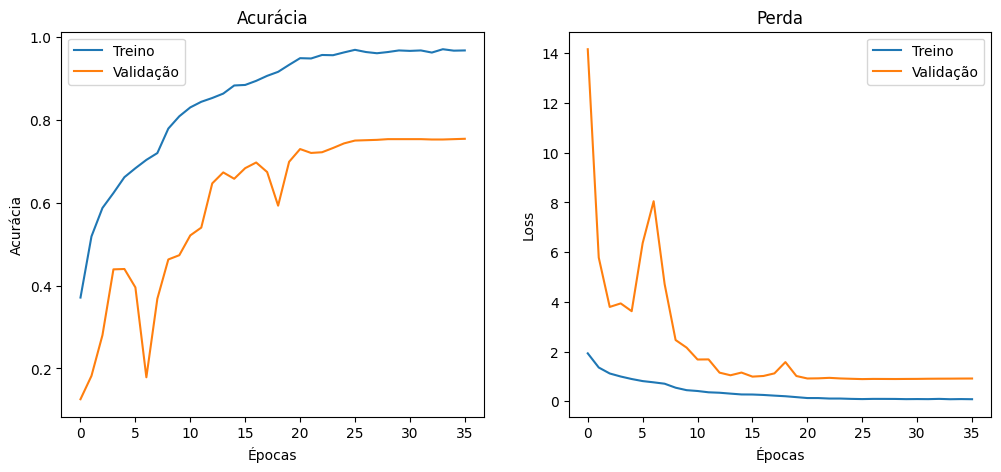

In [11]:
# Histórico de treino
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))

# --- Gráfico de Acurácia ---
plt.subplot(1,2,1)
plt.plot(acc, label="Treino")
plt.plot(val_acc, label="Validação")
plt.title("Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()

# --- Gráfico de Perda ---
plt.subplot(1,2,2)
plt.plot(loss, label="Treino")
plt.plot(val_loss, label="Validação")
plt.title("Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7141 - loss: 0.9824
Acurácia no conjunto de teste: 0.7231
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


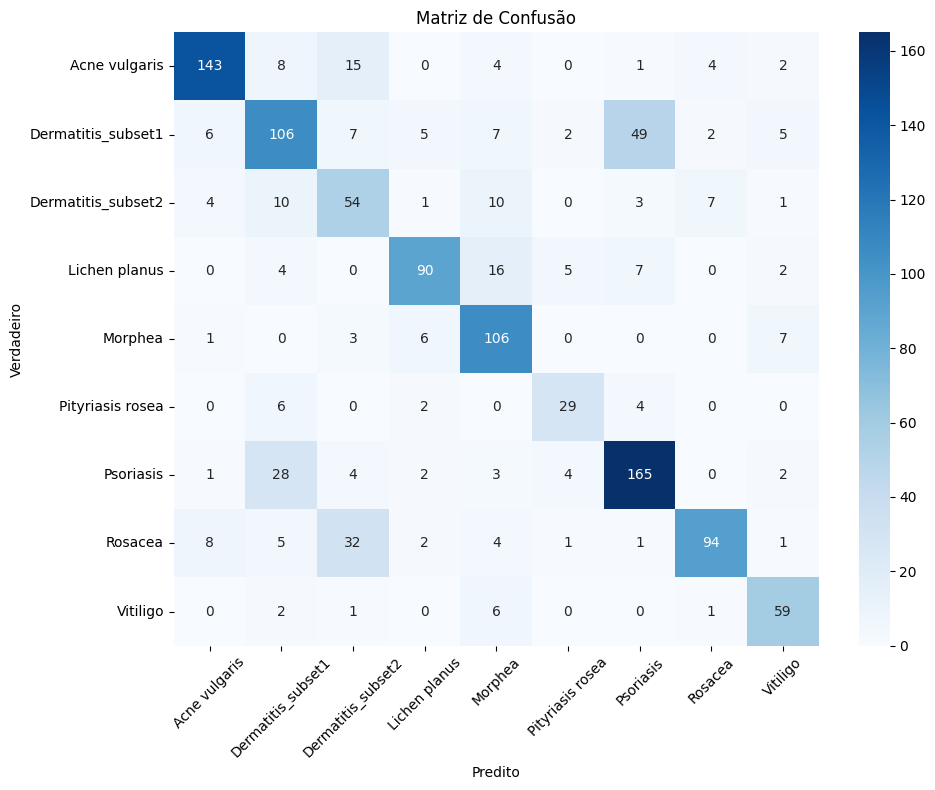

In [12]:
# --- Avaliação ---
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Acurácia no conjunto de teste: {test_acc:.4f}")

# --- Previsões ---
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- Matriz de Confusão ---
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)

# Plot da matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# --- Previsões ---
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- RELATÓRIO COM PRETTYTABLE ---
print("\n" + "="*60)
print("RELATÓRIO DETALHADO DE CLASSIFICAÇÃO")
print("="*60)

# Tabela 1: Métricas Gerais
general_table = PrettyTable()
general_table.field_names = ["Métrica", "Valor"]
general_table.add_row(["Acurácia Teste", f"{test_acc:.4f}"])
general_table.add_row(["Loss Teste", f"{test_loss:.4f}"])
general_table.add_row(["Número de Amostras", len(X_test)])
general_table.add_row(["Número de Classes", len(classes)])
general_table.align = "l"
print("\n📊 MÉTRICAS GERAIS:")
print(general_table)

# Tabela 2: Acurácia por Classe
class_table = PrettyTable()
class_table.field_names = ["Classe", "Acurácia", "Amostras", "Corretas", "Incorretas"]

for i, class_name in enumerate(classes):
    class_mask = y_test == i
    n_samples = np.sum(class_mask)
    if n_samples > 0:
        correct_predictions = np.sum(y_pred_classes[class_mask] == i)
        accuracy = correct_predictions / n_samples
        incorrect = n_samples - correct_predictions
        class_table.add_row([class_name, f"{accuracy:.4f}", n_samples, correct_predictions, incorrect])
    else:
        class_table.add_row([class_name, "0.0000", 0, 0, 0])

class_table.align = "l"
print("\n🎯 ACURÁCIA POR CLASSE:")
print(class_table)

# Tabela 3: Métricas Detalhadas por Classe
precision = precision_score(y_test, y_pred_classes, average=None)
recall = recall_score(y_test, y_pred_classes, average=None)
f1 = f1_score(y_test, y_pred_classes, average=None)

metrics_table = PrettyTable()
metrics_table.field_names = ["Classe", "Precision", "Recall", "F1-Score", "Support"]

for i, class_name in enumerate(classes):
    class_mask = y_test == i
    support = np.sum(class_mask)
    if support > 0:
        metrics_table.add_row([
            class_name,
            f"{precision[i]:.4f}",
            f"{recall[i]:.4f}",
            f"{f1[i]:.4f}",
            support
        ])
    else:
        metrics_table.add_row([class_name, "0.0000", "0.0000", "0.0000", 0])

metrics_table.align = "l"
print("\n📈 MÉTRICAS DETALHADAS:")
print(metrics_table)

# Tabela 4: Resumo das Métricas Globais
macro_precision = precision_score(y_test, y_pred_classes, average='macro')
macro_recall = recall_score(y_test, y_pred_classes, average='macro')
macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')

summary_table = PrettyTable()
summary_table.field_names = ["Métrica", "Valor"]
summary_table.add_row(["Acurácia", f"{test_acc:.4f}"])
summary_table.add_row(["Precision (Macro)", f"{macro_precision:.4f}"])
summary_table.add_row(["Recall (Macro)", f"{macro_recall:.4f}"])
summary_table.add_row(["F1-Score (Macro)", f"{macro_f1:.4f}"])
summary_table.add_row(["F1-Score (Weighted)", f"{weighted_f1:.4f}"])
summary_table.add_row(["Loss", f"{test_loss:.4f}"])

summary_table.align = "l"
print("\n🏆 RESUMO DAS MÉTRICAS GLOBAIS:")
print(summary_table)

# Tabela 5: Análise de Erros
error_indices = np.where(y_test != y_pred_classes)[0]
if len(error_indices) > 0:
    error_table = PrettyTable()
    error_table.field_names = ["Classe Real", "Classe Predita", "Quantidade", "% dos Erros"]
    
    error_counts = {}
    for idx in error_indices:
        true_class = classes[y_test[idx]]
        pred_class = classes[y_pred_classes[idx]]
        key = (true_class, pred_class)
        error_counts[key] = error_counts.get(key, 0) + 1
    
    # Ordena pelos erros mais frequentes
    sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)
    
    for (true_class, pred_class), count in sorted_errors[:10]:
        percentage = (count / len(error_indices)) * 100
        error_table.add_row([true_class, pred_class, count, f"{percentage:.2f}%"])
    
    print("\n❌ PRINCIPAIS ERROS (TOP 10):")
    print(error_table)
else:
    print("\n✅ NENHUM ERRO ENCONTRADO!")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

RELATÓRIO DETALHADO DE CLASSIFICAÇÃO

📊 MÉTRICAS GERAIS:
+--------------------+--------+
| Métrica            | Valor  |
+--------------------+--------+
| Acurácia Teste     | 0.7231 |
| Loss Teste         | 0.9482 |
| Número de Amostras | 1170   |
| Número de Classes  | 9      |
+--------------------+--------+

🎯 ACURÁCIA POR CLASSE:
+--------------------+----------+----------+----------+------------+
| Classe             | Acurácia | Amostras | Corretas | Incorretas |
+--------------------+----------+----------+----------+------------+
| Acne vulgaris      | 0.8079   | 177      | 143      | 34         |
| Dermatitis_subset1 | 0.5608   | 189      | 106      | 83         |
| Dermatitis_subset2 | 0.6000   | 90       | 54       | 36         |
| Lichen planus      | 0.7258   | 124      | 90       | 34         |
| Morphea            | 0.8618   | 123      | 106      | 17         |
| Pityriasis rosea   | 0.7073   | 41       | 29       | 12         |
|